In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.cluster import AgglomerativeClustering

# Load precomputed properties
df = pd.read_csv('properties.csv')

# Apply filters
filtered = df[
    (df['SA'] <= 6) &
    (df['PAINS'] == False) &
    (df['HBA'].between(2, 5)) &
    (df['HBD'].between(0, 2)) &
    (df['TPSA'].between(50, 120)) &
    (df['Gap'].between(1.5, 5.0)) &
    (df['Dipole'].between(1.5, 4.0))
].copy()

print(f"After filtering: {len(filtered)} molecules")

# Generate Morgan fingerprints and cluster
if len(filtered) >= 10:
    fps = [
        AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=1024)
        for s in filtered['SMILES']
    ]
    arr = np.array([list(fp) for fp in fps])
    labels = AgglomerativeClustering(n_clusters=10).fit_predict(arr)
    filtered['Cluster'] = labels

    # Save top pick per cluster
    selected = filtered.groupby('Cluster').first().reset_index()
    selected.to_csv('selected_molecules.csv', index=False)
    print("Saved selected_molecules.csv")
else:
    print("Fewer than 10 molecules passed filters; skipping clustering.")
    selected = filtered.copy()


After filtering: 8076 molecules


[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerator
[12:14:50] DEPRECATION WARNING: please use MorganGenerat

Saved selected_molecules.csv


In [2]:
# UMAP embedding
import umap
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

# Build fingerprints array (safe to recompute here)
fps = [
    AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=1024)
    for s in filtered["SMILES"]
]
arr = np.array([list(fp) for fp in fps], dtype=np.uint8)

# Fit UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_xy = reducer.fit_transform(arr)

# Attach to filtered
filtered["UMAP-1"] = umap_xy[:, 0]
filtered["UMAP-2"] = umap_xy[:, 1]

# Make sure `selected` has SMILES so we can merge coords in
if "SMILES" not in selected.columns:
    # if you used groupby('Cluster').first(), SMILES should be present; just in case:
    raise ValueError("`selected` must contain a 'SMILES' column to merge UMAP coords.")

selected = selected.merge(
    filtered[["SMILES", "UMAP-1", "UMAP-2"]],
    on="SMILES",
    how="left",
    validate="one_to_one"
)

print("UMAP done. Shapes:", filtered.shape, selected.shape)


/home/adroit/miniconda3/envs/cheminf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[12:15:26] DEPRECATION WARNING: please use MorganGenerator
[12:15:26] DEPRECATION WARNING: please use MorganGenerator
[12:15:26] DEPRECATION WARNING: please use MorganGenerator
[12:15:26] DEPRECATION WARNING: please use MorganGenerator
[12:15:26] DEPRECATION WARNING: please use MorganGenerator
[12:15:26] DEPRECATION WARNING: please use MorganGenerator
[12:15:26] DEPRECATION WARNING: please use MorganGenerator
[12:15:26] DEPRECATION WARNING: please use MorganGenerator
[12:15:26] DEPRECATION WARNING: please use MorganGenerator
[12:15:26] DEPRECATION WARNING: please use MorganGenerator
[12:15:26] DEPRECATION WARNING: please use MorganGenerator
[12:15:26] DEPRECATION WARNING: please use MorganGenerator
[12:15:26] DEPRECATIO

UMAP done. Shapes: (8076, 11) (10, 11)


/home/adroit/miniconda3/envs/cheminf/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/adroit/miniconda3/envs/cheminf/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/adroit/miniconda3/envs/cheminf/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/adroit/miniconda3/envs/cheminf/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/adroit/miniconda3/envs/cheminf/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/adroit/miniconda3/envs/cheminf/lib

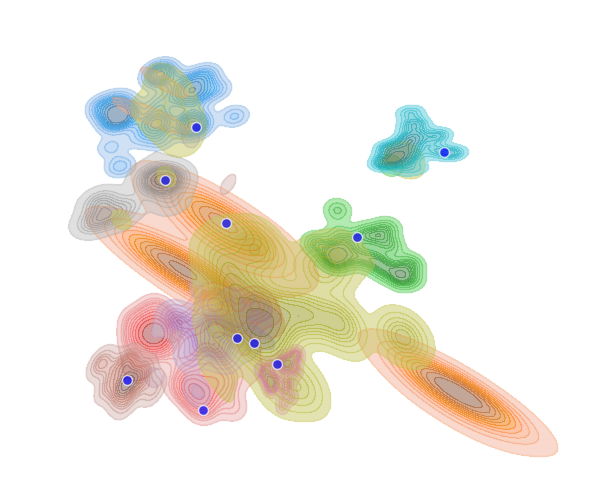

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

plt.figure(figsize=(6, 5))

# Use a soft continuous palette
palette = sns.color_palette("tab10", n_colors=filtered["Cluster"].nunique())

# KDE clouds per cluster (soft alpha)
for cid, color in zip(sorted(filtered["Cluster"].unique()), palette):
    sub = filtered[filtered["Cluster"] == cid]
    if len(sub) < 5:
        continue
    sns.kdeplot(
        x=sub["UMAP-1"], y=sub["UMAP-2"],
        fill=True, levels=12, thresh=0.06, bw_adjust=0.85,
        alpha=0.5, color=color, zorder=1
    )
    sns.kdeplot(
        x=sub["UMAP-1"], y=sub["UMAP-2"],
        fill=False, levels=12, thresh=0.06, bw_adjust=0.85,
        color=color, linewidth=0.5, alpha=0.1, zorder=2
    )

# Overlay selected reps as stars
plt.scatter(
    selected["UMAP-1"], selected["UMAP-2"],
    s=50, marker="o", facecolors="blue", alpha=0.7, edgecolors="white",
    linewidths=1.0, zorder=3
)

# Remove axes, ticks, and spines
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

# Optional: remove axis labels if you want no text at all
ax.set_xlabel("")
ax.set_ylabel("")

plt.tight_layout()
plt.savefig("fig3b.jpg", dpi=500, bbox_inches="tight", transparent=True)
plt.show()


In [4]:
# Save filtered with UMAP (handy if you reopen the notebook)
filtered.to_csv("filtered_with_umap.csv", index=False)
selected.to_csv("selected_with_umap.csv", index=False)
print("Saved filtered_with_umap.csv and selected_with_umap.csv")


Saved filtered_with_umap.csv and selected_with_umap.csv


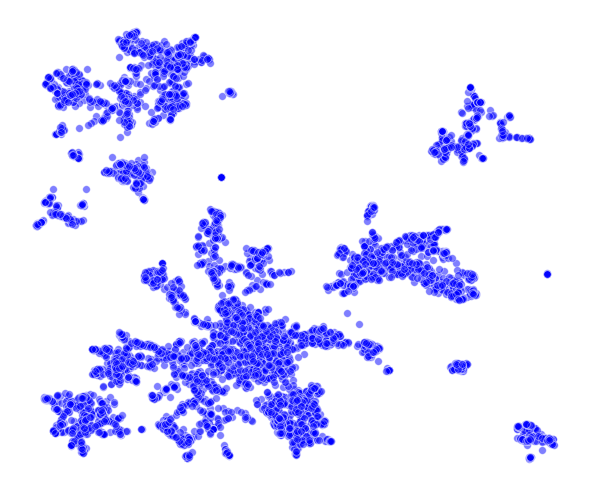

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))

# Scatter plot in one color (red)
plt.scatter(
    filtered["UMAP-1"], filtered["UMAP-2"],
    s=30, c="blue", alpha=0.5, edgecolors="white", linewidths=0.5
)

# Remove axes, ticks, and spines
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove axis labels
ax.set_xlabel("")
ax.set_ylabel("")

plt.tight_layout()
plt.savefig("fig3ai.jpg", dpi=500, bbox_inches="tight", transparent=True)
plt.show()


[12:16:23] Explicit valence for atom # 6 Sb, 7, is greater than permitted
[12:16:23] Explicit valence for atom # 6 Si, 6, is greater than permitted
[12:16:23] Explicit valence for atom # 3 Si, 5, is greater than permitted
[12:16:23] Explicit valence for atom # 9 Si, 6, is greater than permitted
[12:16:23] Explicit valence for atom # 10 Si, 5, is greater than permitted
[12:16:23] Explicit valence for atom # 6 Si, 6, is greater than permitted
[12:16:23] Explicit valence for atom # 6 Sb, 6, is greater than permitted
[12:16:23] Explicit valence for atom # 6 Si, 5, is greater than permitted
[12:16:23] Explicit valence for atom # 6 Si, 5, is greater than permitted
[12:16:23] Explicit valence for atom # 6 Si, 5, is greater than permitted
[12:16:23] Explicit valence for atom # 3 Si, 5, is greater than permitted
[12:16:23] Explicit valence for atom # 6 Si, 5, is greater than permitted
[12:16:23] Explicit valence for atom # 6 Si, 5, is greater than permitted
[12:16:23] Explicit valence for atom 

Dropping 698 invalid SMILES. Indices saved to bad_smiles.csv


[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerator
[12:16:36] DEPRECATION WARNING: please use MorganGenerat

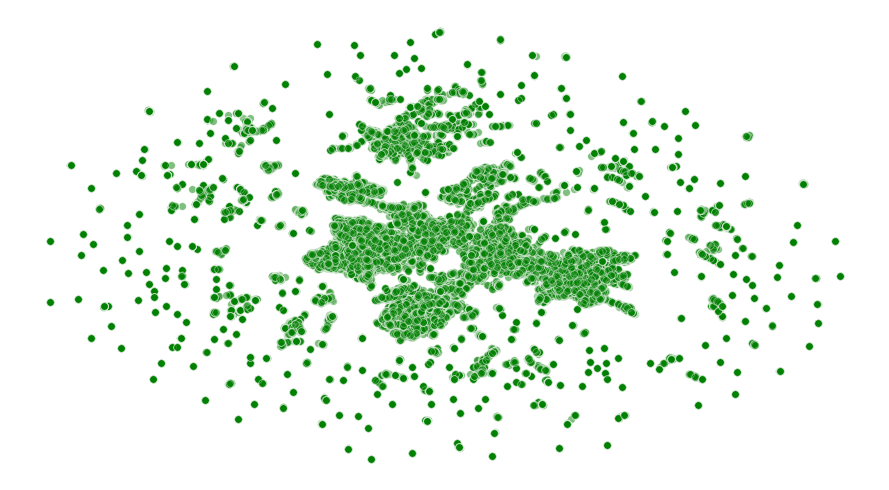

In [6]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import umap
import matplotlib.pyplot as plt

# --- Load ---
df = pd.read_csv("properties1.csv")

# --- Clean & validate SMILES ---
smi = (df["SMILES"]
       .astype(str)
       .str.strip())
valid_mols = []
bad_idx = []

for i, s in smi.items():
    mol = Chem.MolFromSmiles(s)
    if mol is None:
        bad_idx.append(i)
    else:
        valid_mols.append((i, s, mol))

if bad_idx:
    print(f"Dropping {len(bad_idx)} invalid SMILES. Indices saved to bad_smiles.csv")
    df.loc[bad_idx, ["SMILES"]].to_csv("bad_smiles.csv", index=True)

if not valid_mols:
    raise ValueError("No valid SMILES found after filtering.")

# Keep only valid rows
keep_idx = [i for i, _, _ in valid_mols]
df_valid = df.loc[keep_idx].copy()

# --- Fingerprints ---
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
       for _, _, m in valid_mols]
arr = np.array([list(fp) for fp in fps], dtype=np.uint8)

# --- UMAP ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="jaccard", random_state=42)
xy = reducer.fit_transform(arr)
df_valid["UMAP-1"] = xy[:, 0]
df_valid["UMAP-2"] = xy[:, 1]

# --- Blue scatter plot ---
plt.figure(figsize=(9, 5))
plt.scatter(
    df_valid["UMAP-1"], df_valid["UMAP-2"],
    s=30, c="green", alpha=0.5, edgecolors="white", linewidths=0.5
)

ax = plt.gca()
ax.set_xticks([]); ax.set_yticks([])
for sp in ax.spines.values(): sp.set_visible(False)
ax.set_xlabel(""); ax.set_ylabel("")

plt.tight_layout()
plt.savefig("fig3aii.jpg", dpi=500, bbox_inches="tight", transparent=True)
plt.show()
